In [113]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
import networkx as nx

from scipy import stats

import pybel as pb

import time
import csv

import torch
import pyro

pyro.set_rng_seed(101)
torch.set_default_tensor_type(torch.DoubleTensor)
from torch.utils.data import DataLoader

# Create Class of Causal Graph Nodes

In [98]:
# create generic discrete probability function
class cg_node():
    def __init__(self,n_inputs,name,node_type):
        
        self.n_inputs = n_inputs
        self.name = name
        self.node_type = node_type
        
        if n_inputs == 0:
            self.label = 'exogenous'
        else:
            self.label = 'endogenous'
            
        return
    
    def batch_calc(self):
        # break up data into mini-batches for training the node parameters
        self.bat_per_epoch = int(self.n_data/self.batch_size)

        indices = np.zeros((self.batch_size,self.bat_per_epoch)).astype(int)
        ind_temp = np.linspace(0,self.n_data-1,self.n_data).astype(int)
        np.random.shuffle(ind_temp)

        for i in range(0,self.bat_per_epoch):
            indices[:,i] = ind_temp[(self.batch_size*i):(self.batch_size*(i+1))]

        return indices
    
    def reg_calc_bin(self,data_vec,var_j,var_jk):
        # calculate the probability associated with the Bernoulli distribution given the input data
        # use sigmoid to ensure that 0 < p < 1
        return torch.sigmoid(torch.matmul(data_vec,var_j[:self.n_inputs]) + var_j[self.n_inputs] 
            + torch.sum(torch.matmul(data_vec,var_jk)*data_vec,dim=-1))

    def reg_calc_gamma(self,data_vec,var_j,var_jk):
        # calculate the alpha or beta for the Gamma distribution given the input data
        # use abs to ensure that alpha and beta are >= 0
        return torch.abs(torch.matmul(data_vec,var_j[:self.n_inputs]) + var_j[self.n_inputs] 
            + torch.sum(torch.matmul(data_vec,var_jk)*data_vec,dim=-1))

    def bin_log_fcn(self,data_in,p_var):
        # calculate negative (for minimization, not maximization) log-likelihood for the binary variable case
        return -torch.mean(data_in*torch.log(p_var) + (1-data_in)*torch.log(1-p_var))

    def gamma_log_fcn(self,data_in,alpha_var,beta_var):
        # calculate negative (for minimization, not maximization) log-likelihood for the continuous variable case
        return -torch.mean(alpha_var*torch.log(beta_var) + (alpha_var-1)*torch.log(data_in)
            - beta_var*data_in - torch.lgamma(alpha_var))
    
    def p_init(self,input_data,var_data):
        # calculate probability distribution parameters for node probability distributions
        # distribution parameters are quadratic functions of input variables
        # assumes that output variables are either Benoulli- or Gamma-distributed
        
        # need to adjust max_epochs and learning rate
        
        self.n_data = len(input_data)
        
        self.input_data = input_data
        self.var_data = var_data
        
        self.batch_size = 32
        self.max_epoch = 100*self.n_inputs
        self.num_iters = int(self.n_data/self.batch_size)
        
        if self.n_inputs > 0:
            ind_key = np.zeros((self.batch_size,self.num_iters,self.max_epoch))
            ind_key = ind_key.astype(int)
            for i in range(0,self.max_epoch):
                ind_key[:,:,i] = self.batch_calc()
                
            self.ind_key = ind_key

        if self.node_type == 'binary':
            
            if self.n_inputs == 0:
                self.p_jk = []
                self.p_j = -torch.log(1/torch.mean(var_data)-1)
                loss_tot = bin_log_fcn(data_in,self.p_j)
                
            else:
                self.p_j = torch.ones(self.n_inputs+1,requires_grad=True)
                self.p_jk = torch.ones(self.n_inputs,self.n_inputs,requires_grad=True)

                optimizer = torch.optim.Adam([self.p_j,self.p_jk], lr=1/10**(2+self.n_inputs))

                # train log_like_fcn wrt self.p_j                
                
                for i in range(0,self.max_epoch):
                    for j in range(0,self.bat_per_epoch):

                        optimizer.zero_grad()
                        loss = self.bin_log_fcn(var_data[ind_key[:,j,i]],
                            self.reg_calc_bin(input_data[ind_key[:,j,i],:],self.p_j,self.p_jk))
                        optimizer.zero_grad()
                        loss.backward(retain_graph=True)
                        optimizer.step()
                        
                loss_tot = self.bin_log_fcn(var_data,self.reg_calc_bin(input_data,self.p_j,self.p_jk))                
            
        elif self.node_type == 'continuous':            
            
            if self.n_inputs == 0:
                
                self.alpha_jk = []
                self.beta_jk = []
                
                s_temp = torch.log(torch.mean(var_data)) - torch.mean(torch.log(var_data))
                alpha_temp = (3-s_temp + torch.sqrt((s_temp-3)**2 + 24*s_temp))/(12*s_temp)
                beta_temp = alpha_temp/torch.mean(var_data)
                self.alpha_j = alpha_temp
                self.beta_j = beta_temp
                
                loss_tot = self.gamma_log_fcn(var_data,self.alpha_j,self.beta_j)
                
                # plot results
                var_data_plot = [item.item() for item in var_data]
                x_max = torch.max(var_data).item()
                
                x_pts = np.linspace(0,x_max,100)
                alpha_val = alpha_temp.item()
                beta_val = beta_temp.item()
                rat_val = beta_val**alpha_val/sp.special.gamma(alpha_val)
                y_pts = np.asarray([rat_val*item**(alpha_val-1)*np.exp(-beta_val*item) for item in x_pts])
                
                plt.figure()
                hist_counts = plt.hist(var_data_plot,100)
                plt.plot(x_pts,y_pts*np.max(hist_counts[0])/np.max(y_pts))
                plt.show()
                
            else:
                
                # initialize variables
                
                alpha_j_temp = np.zeros(self.n_inputs+1)
                alpha_jk_temp = np.zeros((self.n_inputs,self.n_inputs))
                
                for i in range(0,self.n_inputs):
                    alpha_j_temp[i] = 1/torch.mean(input_data[:,i]).item()
                    for j in range(0,self.n_inputs):
                        alpha_jk_temp[i,j] = 1/(torch.mean(input_data[:,i]).item()
                            *torch.mean(input_data[:,i]).item())
                var_mean = torch.mean(var_data).item()
                        
                alpha_j = torch.tensor(alpha_j_temp*var_mean,requires_grad=True)
                alpha_jk = torch.tensor(alpha_jk_temp*var_mean,requires_grad=True)
                beta_j = torch.tensor(alpha_j_temp,requires_grad=True)
                beta_jk = torch.tensor(alpha_jk_temp,requires_grad=True)

                optimizer = torch.optim.Adam([alpha_j,alpha_jk,beta_j,beta_jk], lr=1/10**(2+self.n_inputs))
                
                # train log_like_fcn wrt self.alpha_j, self.beta_j
                
                for i in range(0,self.max_epoch):
                    for j in range(0,self.bat_per_epoch):

                        optimizer.zero_grad()
                        loss = self.gamma_log_fcn(var_data[ind_key[:,j,i]],
                            self.reg_calc_gamma(input_data[ind_key[:,j,i],:],alpha_j,alpha_jk),
                            self.reg_calc_gamma(input_data[ind_key[:,j,i],:],beta_j,beta_jk))
                        optimizer.zero_grad()
                        loss.backward(retain_graph=True)
                        optimizer.step()
                        
                loss_tot = self.gamma_log_fcn(var_data,self.reg_calc_gamma(input_data,alpha_j,alpha_jk),
                    self.reg_calc_gamma(input_data,beta_j,beta_jk))
                        
                self.alpha_j = alpha_j
                self.alpha_jk = alpha_jk
                self.beta_j = beta_j
                self.beta_jk = beta_jk
                
        else:
            print('node type not supported')
            
        print(loss_tot)
        print()
        self.log_error = loss_tot
        
        return
    
    def sample(self,data_in=[]):
        # sample your output variable given input data (for a non-exogenous variable)
        
        if self.node_type == 'binary':
            if self.n_inputs == 0:
                p_temp = torch.sigmoid(self.p_j)
            else:
                p_temp = self.reg_calc_bin(data_in,self.p_j,self.p_jk)
            
            return torch.squeeze(pyro.sample(self.name,pyro.distributions.Bernoulli(probs=p_temp)).int())
        
        elif self.node_type == 'continuous':
            if self.n_inputs == 0:
                alpha_temp = self.alpha_j
                beta_temp = self.beta_j
            else:                
                alpha_temp = self.reg_calc_gamma(data_in,self.alpha_j,self.alpha_jk)
                beta_temp = self.reg_calc_gamma(data_in,self.beta_j,self.beta_jk)
            
            return torch.squeeze(pyro.sample(self.name,pyro.distributions.Gamma(alpha_temp,beta_temp)))
            
        else:
            print('node type not supported')


In [117]:
class cg_graph():
    
    def __init__(self,str_list=[],bel_graph=[],type_dict=[],only_creases=True):
        
        self.only_creases = only_creases
        
        edge_list = []

        entity_list = []
        
        if str_list:

            for item in str_list:

                sub_ind = item.find('=')

                sub_temp = item[:sub_ind-1]
                obj_temp = item[sub_ind+3:]
                
                rel_temp = item[sub_ind:sub_ind+2]

                if sub_temp not in entity_list:
                    entity_list.append(sub_temp)
                if obj_temp not in entity_list:
                    entity_list.append(obj_temp)
                    
                if only_creases:
                    # ignore hasVariant, partOf relations

                    if rel_temp.find('crease') > 0:
                        edge_list.append([sub_temp,obj_temp,rel_temp])
                
                else:
                    # check for duplicate edges
                    nodes_temp = [sub_temp,obj_temp]
                    list_temp = [[item[0],item[1]] for item in edge_list]
                    if nodes_temp in list_temp:
                        ind_temp = list_temp.index(nodes_temp)
                        edge_list[ind_temp][2] += ',' + rel_temp
                    else:
                        edge_list.append([sub_temp,obj_temp,rel_temp])
                
        elif bel_graph:
            
            for item in bel_graph.edges:
                edge_temp = bel_graph.get_edge_data(item[0],item[1],item[2])
                sub_temp = str(item[0]).replace('"','')
                obj_temp = str(item[1]).replace('"','')
                rel_temp = edge_temp['relation']
                
                if sub_temp not in entity_list:
                    entity_list.append(sub_temp)
                if obj_temp not in entity_list:
                    entity_list.append(obj_temp)
                
                if only_creases:
                    # ignore hasVariant, partOf relations

                    if rel_temp.find('crease') > 0:
                        edge_list.append([sub_temp,obj_temp,rel_temp])
                
                else:
                    # check for duplicate edges
                    nodes_temp = [sub_temp,obj_temp]
                    list_temp = [[item[0],item[1]] for item in edge_list]
                    if nodes_temp in list_temp:
                        ind_temp = list_temp.index(nodes_temp)
                        edge_list[ind_temp][2] += ',' + rel_temp
                    else:
                        edge_list.append([sub_temp,obj_temp,rel_temp])
                

        n_nodes = len(entity_list)
        self.n_nodes = n_nodes

        adj_mat = np.zeros((n_nodes,n_nodes),dtype=int)

        for item in edge_list:
            out_ind = entity_list.index(item[0])
            in_ind = entity_list.index(item[1])
            adj_mat[out_ind,in_ind] = 1
            
        self.edge_list = edge_list
        self.entity_list = entity_list
        self.adj_mat = adj_mat
        
        self.graph = nx.DiGraph(adj_mat)
        
        # check to make sure that it's a DAG
        if nx.algorithms.dag.is_directed_acyclic_graph(self.graph):
            print('The causal graph is a acyclic')
            
        else:
            print('The causal graph has cycles -- this is a problem')
            
            # identify edges that, if removed, would lead to the causal graph being acyclic
            c_bas = list(nx.simple_cycles(self.graph))
            print('There are ' + str(len(c_bas)) + ' simple cycles')
            
            cycle_edge_list = []
            
            for item in c_bas:
                for i in range(0,len(item)):
                    sub_temp = self.entity_list[item[i-1]]
                    obj_temp = self.entity_list[item[i]]
                    rel_temp = [item2[2] for item2 in edge_list if (item2[0] == sub_temp and item2[1] == obj_temp)]
                    cycle_edge_list += [[sub_temp,obj_temp,item2] for item2 in rel_temp]
            print('Cycle edges:')
            for item in cycle_edge_list:
                print(item)
                
        
        node_dict = {}
        
        cont_list = ['a','abundance','complex','complexAbundance','geneAbundance','g','microRNAAbundance','m',
            'populationAbundance','pop','proteinAbundance','p','reaction','rxn','rnaAbundance','r']
        bin_list = ['activity','act','biologicalProcess','bp','molecularActivity','ma']
        
        for i in range(0,n_nodes):
            
            if str_list:
                node_type = type_dict[entity_list[i]]
            elif bel_graph:
                ind_temp = entity_list[i].find('(')
                str_temp = entity_list[i][:ind_temp]
                
                
                if str_temp in cont_list:
                    node_type = 'continuous'
                elif str_temp in bin_list:
                    node_type = 'binary'
                else:
                    node_type = 'continuous'
                    print('BEL node type ' + str_temp + ' not known -- defaulting to continuous')
            
            node_dict[entity_list[i]] = cg_node(np.sum(adj_mat[:,i]),entity_list[i],node_type)
        
        self.node_dict = node_dict
        
        self.cond_list = []
        
        self.sample_dict = {}
        
        self.parent_ind_list = []
        self.child_ind_list = []
        self.parent_name_dict = {}
        self.child_name_dict = {}
        
        self.parent_ind_list = [np.where(self.adj_mat[:,i] > 0)[0] for i in range(0,n_nodes)]
        self.child_ind_list = [np.where(self.adj_mat[i,:] > 0)[0] for i in range(0,n_nodes)]
        
        for i in range(0,n_nodes):
            self.parent_name_dict[entity_list[i]] = [entity_list[item] for item in self.parent_ind_list[i]]
            self.child_name_dict[entity_list[i]] = [entity_list[item] for item in self.child_ind_list[i]]

        return
    
    def remove_edge(self,edge_rem):
        # remove all of the edges in edge_rem
        
        for item in edge_rem:
            ind_remove = [i for i in range(0,len(self.edge_list)) 
                if (self.edge_list[i][0] == edge_rem[0] and self.edge_list[i][1] == edge_rem[1])]
            for ind in ind_remove:
                self.edge_list.remove(self.edge_list[i])
            self.adj_mat[self.entity_list.index(item[0]),self.entity_list.index(item[1])] = 0
            
        self.graph = nx.DiGraph(self.adj_mat)
        
        self.parent_ind_list = []
        self.child_ind_list = []
        self.parent_name_dict = {}
        self.child_name_dict = {}
        
        self.parent_ind_list = [np.where(self.adj_mat[:,i] > 0)[0] for i in range(0,self.n_nodes)]
        self.child_ind_list = [np.where(self.adj_mat[i,:] > 0)[0] for i in range(0,self.n_nodes)]
        
        for i in range(0,self.n_nodes):
            self.parent_name_dict[self.entity_list[i]] = [
                self.entity_list[item] for item in self.parent_ind_list[i]]
            self.child_name_dict[self.entity_list[i]] = [
                self.entity_list[item] for item in self.child_ind_list[i]]
        return
    
    def prob_init(self,data_in):
        # initialize all of the nodes' probability distributions given data_in
        
        exog_list = []
        prob_dict = {}
        
        for name in self.node_dict:
            i = self.entity_list.index(name)
            data_in_temp = data_in[:,self.parent_ind_list[i]]
            data_out_temp = data_in[:,i]
            print(name)
            self.node_dict[name].p_init(data_in_temp,data_out_temp)
            
            if self.node_dict[name].n_inputs == 0:
                exog_list.append(name)
            #prob_dict[name] = self.node_dict[name].prob_dist
        
        self.exog_list = exog_list
        #self.prob_dict = prob_dict

        return
        
    def model_sample(self):
        # produce a dictionary of samples for all variables in the graph
        
        # define exogenous samples
        
        sample_dict = {}
        
        for item in self.exog_list:
            sample_dict[item] = self.node_dict[item].sample()
            
        flag = 0
        while flag == 0:
            
            # find all nodes not in sample_dict with parents entirely in sample dict and sample those nodes
            for item in self.entity_list:
                if (item not in sample_dict 
                    and np.all([item2 in sample_dict for item2 in self.parent_name_dict[item]])):
                    
                    sample_dict[item] = self.node_dict[item].sample(
                        torch.tensor([sample_dict[item2] for item2 in self.parent_name_dict[item]]))
            
            # if sample dict has all of the nodes in entity list, stop
            if sorted([item for item in sample_dict]) == sorted(self.entity_list):
                flag = 1
            
        
        return sample_dict
    
    def model_cond_sample(self,data_dict):
        # sample the graph given the conditioned variables in data_dict
        
        data_in = {}
        for item in data_dict:
            data_in[item] = data_dict[item]
        
        cond_model = pyro.condition(self.model_sample,data=data_in)
        return cond_model()
        
    def model_do_sample(self,do_dict):
        # sample the graph given the do-variables in do_dict
        
        data_in = {}
        for item in do_dict:
            data_in[item] = do_dict[item]
        
        do_model = pyro.do(self.model_sample,data=data_in)
        return do_model()
    
    def model_do_cond_sample(self,do_dict,data_dict):
        # sample the graph given do-variables in do_dict and conditioned variables in data_dict
        
        if np.any([[item1 == item2 for item1 in do_dict] for item2 in data_dict]):
            print('overlapping lists!')
            return
        else:
            do_dict_in = {}
            for item in do_dict:
                do_dict_in[item] = do_dict[item]
                
            data_dict_in = {}
            for item in data_dict:
                data_dict_in[item] = data_dict[item]
            
            do_model = pyro.do(self.model_sample,data=do_dict_in)
            cond_model = pyro.condition(do_model,data=data_dict_in)
            return cond_model()
    
    def model_counterfact(self,obs_dict,do_dict_counter):
        # find conditional distribution on exogenous variables given observations in obs_dict 
        # and do variable values in do_dict_counter
        cond_dict = self.model_cond_sample(obs_dict)
        cond_dict_temp = {}
        for item in self.exog_list:
            cond_dict_temp[item] = cond_dict[item]
        
        # evaluate observed variables given this condition distribution and do_dict_counter do-variables
        return self.model_do_cond_sample(do_dict_counter,cond_dict_temp)
        
        
    def cond_mut_info(self,target,test,cond,data_in):
        # calculate the conditional mutual information between target and test given data_in - I(target:test|cond)
        # just uses input data, but have to bin data (creating discrete distribution) to perform calculations
        
        n_data = len(data_in)
        
        data_in_np = np.asarray([[item2.item() for item2 in item] for item in data_in])        
        cond_temp = cond
        
        if not cond:
            # find parents of target
            for item in target:
                for item2 in self.parent_name_dict[item]:
                    if item2 not in cond_temp:
                        cond_temp.append(item2)
        
        
        target_inds = [self.entity_list.index(item) for item in target]
        test_inds = [self.entity_list.index(item) for item in test]
        cond_inds = [self.entity_list.index(item) for item in cond_temp]

        total_inds = target_inds + test_inds + cond_inds
        n_tot = len(total_inds)
        n_target = len(target_inds)
        n_test = len(test_inds)
        n_cond = len(cond_inds)

        # bin the incoming data
        data_bin = np.histogramdd((data_in_np[:,total_inds]),bins=10)[0]/n_data

        
        # calculate each joint entropy
        
        all_inds = list(range(0,n_tot))
        
        p_z = np.sum(data_bin,tuple(all_inds[:n_target+n_test]))
        H_z = np.sum(p_z*np.log(p_z+1e-6))
        
        p_xz = np.sum(data_bin,tuple(all_inds[n_target:n_target+n_test]))
        H_xz = np.sum(p_xz*np.log(p_xz+1e-6))
        
        p_yz = np.sum(data_bin,tuple(all_inds[:n_target]))
        H_yz = np.sum(p_yz*np.log(p_yz+1e-6))
        
        H_xyz = np.sum(data_bin*np.log(data_bin+1e-6))
                
        return H_xz + H_yz - H_xyz - H_z
        
    def g_test(self,name,data_in):
        # do the G-test on a single variable of interest 
        # determine if causal graph captures underlying distribution
        # have to bin data to perform calculations
        
        name_ind = self.entity_list.index(name[0])
        
        if self.node_dict[name[0]].node_type == 'binary':
            # bin the data
            binned_data = torch.histc(data_in[:,name_ind],2,-0.5,1.5)
            
            # generate sample data
            data_samp = torch.tensor([self.model_sample()[name[0]] for i in range(0,len(data_in))])
            binned_samp = torch.histc(data_samp,2,-0.5,1.5)
            
        else:
            data_max = torch.max(data_in[:,name_ind])
            data_min = torch.min(data_in[:,name_ind])

            # bin the data
            binned_data = torch.histc(data_in[:,name_ind],100,data_min,data_max)

            # generate sample data
            data_samp = torch.tensor([self.model_sample()[name[0]] for i in range(0,len(data_in))])
            binned_samp = torch.histc(data_samp,100,data_min,data_max)
        
        
        g_val = 2*torch.sum(binned_data*torch.log(binned_data/(binned_samp+1e-6)))
        
        dof = len(data_in) - 1
        
        p_val = 1-sp.stats.chi2.cdf(g_val.item(), dof)
        
        return g_val,p_val
        
  
    def write_to_cf(self,filename,spacing):
        # write the causal graph to a text file to import into causal fusion
        
        pos_dict = nx.drawing.layout.planar_layout(self.graph)
        
        write_dict = {}
        write_dict['name'] = 'causal_graph'
        
        # write nodes
        write_dict['nodes'] = []
        for i in range(0,len(self.entity_list)):
            name = self.entity_list[i]
            
            write_dict['nodes'].append({})
            
            write_dict['nodes'][-1]['id'] = 'node' + str(i)
            write_dict['nodes'][-1]['name'] = name
            write_dict['nodes'][-1]['label'] = name
            write_dict['nodes'][-1]['type'] = 'basic'
            write_dict['nodes'][-1]['metadata'] = {}
            write_dict['nodes'][-1]['metadata']['x'] = spacing*pos_dict[i][0]
            write_dict['nodes'][-1]['metadata']['y'] = spacing*pos_dict[i][1]
            write_dict['nodes'][-1]['metadata']['label'] = ''
            write_dict['nodes'][-1]['metadata']['shape'] = 'ellipse'
            write_dict['nodes'][-1]['metadata']['fontSize'] = 14
            write_dict['nodes'][-1]['metadata']['sizeLabelMode'] = 5
            write_dict['nodes'][-1]['metadata']['font'] = {}
            write_dict['nodes'][-1]['metadata']['font']['size'] = 14
            write_dict['nodes'][-1]['metadata']['size'] = 14
            write_dict['nodes'][-1]['metadata']['labelNodeId'] = 'node' + str(i) + 'ID'
            write_dict['nodes'][-1]['metadata']['labelNodeOffset'] = {}
            write_dict['nodes'][-1]['metadata']['labelNodeOffset']['x'] = 0
            write_dict['nodes'][-1]['metadata']['labelNodeOffset']['y'] = 0
            write_dict['nodes'][-1]['metadata']['labelOffset'] = {}
            write_dict['nodes'][-1]['metadata']['labelOffset']['x'] = 0
            write_dict['nodes'][-1]['metadata']['labelOffset']['y'] = 0
            write_dict['nodes'][-1]['metadata']['shadow'] = {}
            write_dict['nodes'][-1]['metadata']['shadow']['color'] = '#00000080'
            write_dict['nodes'][-1]['metadata']['shadow']['size'] = 0
            write_dict['nodes'][-1]['metadata']['shadow']['x'] = 0
            write_dict['nodes'][-1]['metadata']['shadow']['y'] = 0
            
        # write edges
        write_dict['edges'] = []
        
        for i in range(0,len(self.edge_list)):
            
            item = self.edge_list[i]
            from_node = self.entity_list.index(item[0])
            to_node = self.entity_list.index(item[1])
            
            write_dict['edges'].append({})
            
            write_dict['edges'][-1]['id'] = 'node' + str(from_node) + '->node' + str(to_node)
            write_dict['edges'][-1]['from'] = item[0]
            write_dict['edges'][-1]['to'] = item[1]
            write_dict['edges'][-1]['type'] = 'directed'
            write_dict['edges'][-1]['metadata'] = {}
            write_dict['edges'][-1]['metadata']['isLabelDraggable'] = True
            write_dict['edges'][-1]['metadata']['label'] = ''
            
        
        write_dict['task'] = {}
        
        write_dict['metadata'] = {}
        
        write_dict['project_id'] = '123456789'
        write_dict['_fileType'] = 'graph'
                
        with open(filename + '.json', 'w') as json_file:
            json.dump(write_dict, json_file)
        

In [100]:
str_list = ['temp =| cloudy','cloudy => rainy','temp => icream','rainy =| icream']
type_dict = {}
type_dict['temp'] = 'continuous'
type_dict['cloudy'] = 'continuous'
type_dict['rainy'] = 'continuous'
type_dict['icream'] = 'continuous'
graph_test = cg_graph(str_list=str_list,type_dict=type_dict,only_creases=False)

The causal graph is a acyclic


In [114]:
bel_temp = pb.from_bel_script('sag_bel_graph.txt')

In [118]:
graph_test = cg_graph(bel_graph=bel_temp)

The causal graph is a acyclic


temp


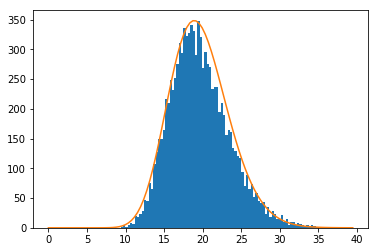

tensor(2.7520)

cloudy
tensor(-0.2561, grad_fn=<NegBackward>)

rainy
tensor(1.0858, grad_fn=<NegBackward>)

icream
tensor(-1.4748, grad_fn=<NegBackward>)

['temp']


In [101]:
graph_test.prob_init(tot_data)
print(graph_test.exog_list)

In [121]:
for item in graph_test.node_dict:
    print(graph_test.node_dict[item].name)
    print(graph_test.node_dict[item].node_type)
    print()

complex(a(CHEBI:26667 ! sialic acid), p(HGNC:1659 ! CD33))
continuous

p(HGNC:1659 ! CD33)
continuous

a(CHEBI:26667 ! sialic acid)
continuous

p(HGNC:1659 ! CD33, pmod(Ph))
continuous

p(HGNC:9658 ! PTPN6)
continuous

p(HGNC:9644 ! PTPN11)
continuous

p(HGNC:11491 ! SYK)
continuous

p(HGNC:17761 ! TREM2)
continuous

p(HGNC:12449 ! TYROBP)
continuous



In [ ]:
for item in graph_test.node_dict:
    print(graph_test.node_dict[item].alpha_j)
    print(graph_test.node_dict[item].alpha_jk)
    print(graph_test.node_dict[item].beta_j)
    print(graph_test.node_dict[item].beta_jk)
    print()

In [ ]:
graph_test.write_to_cf('sag_graph',300)

In [ ]:
for item in graph_test.node_dict:
    print(item)
    print(graph_test.node_dict[item].node_type)
    print()

In [102]:
graph_test.model_sample()

{'cloudy': tensor(0.6033, grad_fn=<SqueezeBackward0>),
 'icream': tensor(0.0011, grad_fn=<SqueezeBackward0>),
 'rainy': tensor(1.5987, grad_fn=<SqueezeBackward0>),
 'temp': tensor(15.0858)}

In [103]:
cond_dict = {}
cond_dict['cloudy'] = torch.Tensor([0.5])

cond_test = graph_test.model_cond_sample(cond_dict)

for item in cond_test:
    print(item)
    print(cond_test[item])
    print()

temp
tensor(18.7738)

cloudy
tensor(0.5000)

rainy
tensor(1.5028, grad_fn=<SqueezeBackward0>)

icream
tensor(2.1478, grad_fn=<SqueezeBackward0>)



In [104]:
do_dict = {}
do_dict['rainy'] = torch.Tensor([2.5])

do_test = graph_test.model_do_sample(do_dict)

for item in do_test:
    print(item)
    print(do_test[item])
    print()



temp
tensor(15.0768)

cloudy
tensor(0.6302, grad_fn=<SqueezeBackward0>)

rainy
tensor(2.5000)

icream
tensor(0.1782, grad_fn=<SqueezeBackward0>)



In [105]:
do_cond_test = graph_test.model_do_cond_sample(do_dict,cond_dict)
for item in do_cond_test:
    print(item)
    print(do_cond_test[item])
    print()

temp
tensor(18.5983)

cloudy
tensor(0.5000)

rainy
tensor(2.5000)

icream
tensor(0.1034, grad_fn=<SqueezeBackward0>)



In [106]:
obs_dict = {}
obs_dict['icream'] = torch.Tensor([0.5])
obs_dict['rainy'] = torch.Tensor([0.8])

do_dict = {}
do_dict['rainy'] = torch.Tensor([1.5])


counter_test = graph_test.model_counterfact(obs_dict,do_dict)
for item in counter_test:
    print(item)
    print(counter_test[item])
    print()


temp
tensor(17.4324)

cloudy
tensor(0.0435, grad_fn=<SqueezeBackward0>)

rainy
tensor(1.5000)

icream
tensor(0.0931, grad_fn=<SqueezeBackward0>)



In [108]:
print(graph_test.cond_mut_info(['icream'],['rainy'],['temp'],tot_data))

-0.15610234126017097


In [107]:
a = graph_test.g_test(['icream'],tot_data)
print(a)

(tensor(6026.3399), 1.0)


In [ ]:
print(dir(graph_test))
print()
print(graph_test.entity_list)
print(graph_test.adj_mat)

In [5]:
def indep_vars(n_samples):
    
    T_list = []
    C_list = []
    P_list = []
    
    for i in range(0,n_samples):
        
        #x = pyro.sample("x_{}".format(i), pyro.distributions.Normal(20,5))
        
        #T_temp = pyro.distributions.Normal(20,5).sample()
        #C_temp = 0.5*pyro.distributions.Beta(1,1+T_temp/10).sample() + 0.5*pyro.distributions.Uniform(0,1).sample()
        #P_temp = (0.5*pyro.distributions.Exponential(1).sample() 
            #+ 0.5*pyro.distributions.Exponential(1/(C_temp+1)).sample())
        
        T_list.append(pyro.sample("T_{}".format(i), pyro.distributions.LogNormal(2.96,0.2)))
        
        C_list.append(0.5*pyro.sample("C1_{}".format(i),pyro.distributions.Beta(1,1+T_list[-1]/10)) 
            + 0.5*pyro.sample("C2_{}".format(i),pyro.distributions.Uniform(0,1)))
        P_list.append(0.5*pyro.sample("P1_{}".format(i), pyro.distributions.Exponential(1))
            + 0.5*pyro.sample("P2.{}".format(i),pyro.distributions.Exponential(1/(C_list[-1]+1))))
        
    return T_list,C_list,P_list

def dep_vars(T_list,C_list,P_list):
    
    n_pts = len(T_list)
    
    I_list = []
    
    for i in range(0,n_pts):
        
        T_temp = T_list[i]
        C_temp = C_list[i]
        P_temp = P_list[i]
        
        if P_temp > 2.5 or T_temp < 15:
            I_list.append(pyro.sample("I_{}".format(i),pyro.distributions.Bernoulli(0))+1e-6)
        else:
            I_list.append(pyro.sample("I_{}".format(i),
                pyro.distributions.Beta(2*(2.5-P_temp)*(T_temp-12)/(2.5*12),2))+1e-6)
            #I_temp = torch.tensor(0.5)
        
    return I_list

In [6]:
n_data = 10000
temp,cloud,precip = indep_vars(n_data)
icream = dep_vars(temp,cloud,precip)

In [7]:
tot_data = torch.Tensor([temp,cloud,precip,icream])
tot_data = tot_data.T
print(tot_data.size())
print(tot_data.dtype)

torch.Size([10000, 4])
torch.float64


In [ ]:
print(torch.sum(torch.lt(tot_data,1e-6)))

In [20]:
tot_data_np = np.asarray([[item2.item() for item2 in item] for item in tot_data])
print(tot_data_np)
print(type(tot_data_np))
print(np.shape(tot_data_np))

[[1.46128135e+01 3.81122879e-01 9.47273093e-01 1.00000000e-06]
 [2.39220507e+01 5.79113534e-01 1.73934534e+00 2.86442721e-01]
 [2.02819826e+01 2.81136566e-01 1.75762778e+00 6.62767430e-01]
 ...
 [2.34347768e+01 1.67162027e-01 1.35281624e+00 6.14039732e-01]
 [1.55175092e+01 4.51119644e-01 1.17293660e+00 1.13925318e-04]
 [1.93683867e+01 1.10350912e-01 3.65258173e-01 3.23652825e-01]]
<class 'numpy.ndarray'>
(10000, 4)
